## Risk calculations

This notebook calculates the risk of infection of the three reference pathogens:

   - *Rotavirus*
   - *Campylobacter jejuni*
   - *Cryptosporidium parvum*

The basis of the calcualtion is a configured **RiskAssessment** instance. 

In [18]:
from qmratool.models import *
#import pymc3 as pm
import plotly.express as px
#import arviz as az
import numpy as np
import pandas as  pd
import plotly.express as px
from plotly.offline import plot
from django_pandas.io import read_frame
import decimal


In [19]:
RiskAssessment.objects.all()

<QuerySet [<RiskAssessment: Second assessment>, <RiskAssessment: New risk assessment>, <RiskAssessment: Braunschweig status quo>, <RiskAssessment: Braunschweig Filtration UV>, <RiskAssessment: Braunschweig Filtration>]>

In [20]:
ra = RiskAssessment.objects.get(name = "Braunschweig status quo")

In [21]:
# Selecting inflow concentration based in source water type
df_inflow = read_frame(Inflow.objects.filter(water_source=ra.source).values("min", "max", "pathogen__pathogen", "water_source__water_source_name"))
df_inflow = df_inflow[df_inflow["pathogen__pathogen"].isin(["Rotavirus", "Campylobacter jejuni", "Cryptosporidium parvum"])]
  

In [22]:
# Querying dose response parameters based on pathogen inflow
dr_models = read_frame(DoseResponse.objects.filter(pathogen__in=Pathogen.objects.filter(pathogen__in=df_inflow["pathogen__pathogen"])))


In [23]:
# Querying for Logremoval based on selected treatments
df_treatment=read_frame(LogRemoval.objects.filter(treatment__in=ra.treatment.all()).values("min", "max", "treatment__name", "pathogen_group__pathogen_group"))


In [24]:
# Summarizing treatment to treatment max and treatment min
df_treatment_summary=df_treatment.groupby(["pathogen_group__pathogen_group"]).sum().reset_index()
   

In [25]:
def annual_risk(nexposure, event_probs):
    return 1-np.prod(1-np.random.choice(event_probs, nexposure, True))


In [26]:
df_inflow

,min,max,pathogen__pathogen,water_source__water_source_name
4,50.00000000,5000.00000000,Rotavirus,"sewage, raw"
5,100.00000000,1000000.00000000,Campylobacter jejuni,"sewage, raw"
6,1.00000000,10000.00000000,Cryptosporidium parvum,"sewage, raw"


In [66]:
results = pd.DataFrame()

for index, row in df_inflow.iterrows():
    d = df_inflow.loc[df_inflow["pathogen__pathogen"] ==row["pathogen__pathogen"]]
    dr = dr_models.loc[dr_models["pathogen"]==row["pathogen__pathogen"]]

    if row["pathogen__pathogen"] == "Rotavirus":
        selector = "Viruses" 
    elif row["pathogen__pathogen"]== "Cryptosporidium parvum":
        selector = "Protozoa"
    else:
        selector = "Bacteria"
    #result.append(selector)

    df_treat = df_treatment_summary[df_treatment_summary["pathogen_group__pathogen_group"]==selector]



    risk_df = pd.DataFrame({"inflow": np.random.normal(loc=(np.log10(float(d["min"])+10**(-8))+np.log10(float(d["max"]) ))/2, 
                                                        scale = (np.log10(float(d["max"]))-np.log10(float(d["min"])+10**(-8) ))/4,  
                                                        size = 10000),
                            "LRV": np.random.uniform(low= df_treat["min"], 
                                                     high= df_treat["min"], 
                                                     size= 10000),
                            "LRVmax": np.random.uniform(low= df_treat["max"], 
                                                     high= df_treat["max"], 
                                                     size= 10000)})
    risk_df["outflow"]=risk_df["inflow"] - risk_df["LRV"]
    risk_df["outflow_min"]=risk_df["inflow"] - risk_df["LRVmax"]
    
    risk_df["dose"] = (10**risk_df["outflow"])*float(ra.exposure.volume_per_event)
    risk_df["dose_min"] = (10**risk_df["outflow_min"])*float(ra.exposure.volume_per_event)
    
    if selector != "Protozoa":
        risk_df["probs"] = 1 - (1 + (risk_df["dose"]) * (2 ** (1/float(dr.alpha)) - 1)/float(dr.n50)) ** -float(dr.alpha)
        risk_df["probs_min"] = 1 - (1 + (risk_df["dose_min"]) * (2 ** (1/float(dr.alpha)) - 1)/float(dr.n50)) ** -float(dr.alpha)
    
    else:
        risk_df["probs"] = 1 - np.exp(-float(dr.k)*(risk_df["dose"]))
        risk_df["probs_min"] = 1 - np.exp(-float(dr.k)*(risk_df["dose_min"]))

    results[row["pathogen__pathogen"]+"_MinimumLRV"] = [annual_risk(int(ra.exposure.events_per_year), risk_df["probs"] ) for _ in range(1000)]
    results[row["pathogen__pathogen"]+"_MaximumLRV"] = [annual_risk(int(ra.exposure.events_per_year), risk_df["probs_min"] ) for _ in range(1000)]


In [67]:
results_long = pd.melt(results)
results_long["log probability"] = np.log10(results_long["value"])

In [68]:
results_long["pathogen"] = results_long["variable"].str.split("_", expand=True)[0]
results_long["stat"] = results_long["variable"].str.split("_", expand=True)[1]

In [71]:
fig = px.box(results_long, 
             x="stat", 
             y="value", color="pathogen",
                            points="all",  
                            log_y =True, 
                            title="Risk as probability of infection per year",
                            color_discrete_sequence=["#75c3ff", "#007c9f", "#212c52"])


fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Risk assessment as probability of infection per year'},
    xaxis_title = "",
    yaxis_title = "Probability of infection per year",
    #markersize= 12,
    )

fig.update_traces(marker_size = 8)#['#75c3ff', "red"],#, marker_line_color='#212c52',

fig.update_layout(legend=dict(
                 orientation="h",
                 yanchor="top",
                 y=-.1,
                 xanchor="left",
                x=0))



fig.show()



In [72]:
fig.show()

In [33]:
mx = results_long.groupby("variable").max()

In [35]:
results_long

,variable,value,log probability
0,Rotavirus_max,1.000000,-3.528485e-10
1,Rotavirus_max,1.000000,-1.216420e-08
2,Rotavirus_max,1.000000,-1.249722e-10
3,Rotavirus_max,1.000000,-3.414168e-10
4,Rotavirus_max,1.000000,-2.300412e-10
...,...,...,...
5995,Cryptosporidium parvum_min,0.045327,-1.343638e+00
5996,Cryptosporidium parvum_min,0.100176,-9.992376e-01
5997,Cryptosporidium parvum_min,0.040029,-1.397627e+00
5998,Cryptosporidium parvum_min,0.034029,-1.468149e+00


In [50]:
results_long["pathogen"] = results_long["variable"].str.split("_", expand=True)[0]

In [51]:
results_long["stat"] = results_long["variable"].str.split("_", expand=True)[1]

In [52]:
results_long

,variable,value,log probability,pathogen,stat
0,Rotavirus_max,1.000000,-3.528485e-10,Rotavirus,max
1,Rotavirus_max,1.000000,-1.216420e-08,Rotavirus,max
2,Rotavirus_max,1.000000,-1.249722e-10,Rotavirus,max
3,Rotavirus_max,1.000000,-3.414168e-10,Rotavirus,max
4,Rotavirus_max,1.000000,-2.300412e-10,Rotavirus,max
...,...,...,...,...,...
5995,Cryptosporidium parvum_min,0.045327,-1.343638e+00,Cryptosporidium parvum,min
5996,Cryptosporidium parvum_min,0.100176,-9.992376e-01,Cryptosporidium parvum,min
5997,Cryptosporidium parvum_min,0.040029,-1.397627e+00,Cryptosporidium parvum,min
5998,Cryptosporidium parvum_min,0.034029,-1.468149e+00,Cryptosporidium parvum,min


In [32]:
new_df =pd.melt(results, id_vars=['subject_type','subject'], var_name='abc').sort_values(by=['subject', 'subject_type'])

new_df['cond']=new_df['abc'].apply(lambda x: (x.split('_'))[0])
new_df['value_type']=new_df.pop('abc').apply(lambda x: (x.split('_'))[-1])
new_df

,Rotavirus_max,Rotavirus_min,Campylobacter jejuni_max,Campylobacter jejuni_min,Cryptosporidium parvum_max,Cryptosporidium parvum_min
0,1.0,0.739246,0.999992,0.223519,0.996867,0.114980
1,1.0,0.782288,0.999950,0.338312,0.999938,0.066374
2,1.0,0.814027,0.999754,0.221226,0.992516,0.040059
3,1.0,0.684338,0.999910,0.063331,0.898403,0.107911
4,1.0,0.728106,0.999862,0.098847,0.999942,0.063597
...,...,...,...,...,...,...
995,1.0,0.820807,0.999923,0.215044,0.968645,0.045327
996,1.0,0.752800,0.999988,0.243915,0.985542,0.100176
997,1.0,0.780325,0.999812,0.292688,0.996043,0.040029
998,1.0,0.651547,0.997629,0.153877,0.997444,0.034029


In [47]:
mn =results_long.groupby("variable").min()

In [50]:
results_long.groupby("variable").describe()

value                                    \
                             count      mean           std       min   
variable                                                               
Campylobacter jejuni        1000.0  0.999875  2.324016e-04  0.996673   
Campylobacter jejuni_min    1000.0  0.205142  9.449437e-02  0.051105   
Cryptosporidium parvum      1000.0  0.984426  3.321524e-02  0.680743   
Cryptosporidium parvum_min  1000.0  0.078439  6.240358e-02  0.013514   
Rotavirus                   1000.0  1.000000  6.784688e-09  1.000000   
Rotavirus_min               1000.0  0.756705  5.016759e-02  0.599390   

                                                                    \
                                 25%       50%       75%       max   
variable                                                             
Campylobacter jejuni        0.999873  0.999950  0.999981  1.000000   
Campylobacter jejuni_min    0.136631  0.181999  0.252949  0.608983   
Cryptosporidium parvum      0.985064  0.998098  0.999937  1.000000   
Cryptosporidium parvum_min  0.041818  0.058628  0.090954  0.584256   
Rotavirus                   1.000000  1.000000  1.000000  1.000000   
Rotavirus_min               0.722056  0.759413  0.792694  0.899226   

                           log probability                              \
                                     count          mean           std   
variable                                                                 
Campylobacter jejuni                1000.0 -5.424861e-05  1.010112e-04   
Campylobacter jejuni_min            1000.0 -7.309011e-01  1.932583e-01   
Cryptosporidium parvum              1000.0 -7.090519e-03  1.584598e-02   
Cryptosporidium parvum_min          1000.0 -1.194115e+00  2.606773e-01   
Rotavirus                           1000.0 -1.041496e-09  2.946552e-09   
Rotavirus_min                       1000.0 -1.220424e-01  2.915248e-02   

                                                                      \
                                     min           25%           50%   
variable                                                               
Campylobacter jejuni       -1.447334e-03 -5.536592e-05 -2.191342e-05   
Campylobacter jejuni_min   -1.291536e+00 -8.644523e-01 -7.399307e-01   
Cryptosporidium parvum     -1.670167e-01 -6.535426e-03 -8.268000e-04   
Cryptosporidium parvum_min -1.869221e+00 -1.378637e+00 -1.231896e+00   
Rotavirus                  -5.527871e-08 -9.242816e-10 -2.999304e-10   
Rotavirus_min              -2.222903e-01 -1.414292e-01 -1.195221e-01   

                                                        
                                     75%           max  
variable                                                
Campylobacter jejuni       -8.049996e-06 -1.702742e-07  
Campylobacter jejuni_min   -5.969702e-01 -2.153951e-01  
Cryptosporidium parvum     -2.755552e-05  0.000000e+00  
Cryptosporidium parvum_min -1.041180e+00 -2.333971e-01  
Rotavirus                  -1.129886e-10 -1.538440e-12  
Rotavirus_min              -1.008946e-01 -4.613131e-02

<AxesSubplot:xlabel='variable'>

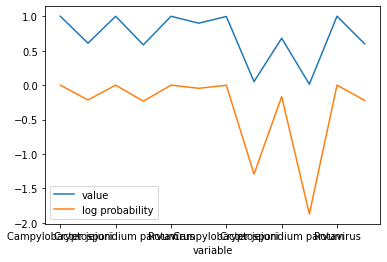

In [42]:
pd.concat([mx, mn]).plot()

,value,log probability


In [60]:
 # reshaping dataframe for plotting
df_inflow2 = pd.melt(df_inflow, ("pathogen__pathogen", "water_source__water_source_name"))
df_inflow2 = df_inflow2[df_inflow2.pathogen__pathogen.isin(["Rotavirus", "Cryptosporidium parvum", "Campylobacter jejuni"])]
df_inflow2 = df_inflow2.rename(columns={"pathogen__pathogen": "Pathogen", "variable":""})

In [61]:
fig = px.bar(df_inflow2, 
             x="", y = "value", 
             log_y=True,
            facet_col="Pathogen", 
            barmode="group", 
            color_discrete_sequence=["#007c9f", "rgb(0, 86, 100)", "grey", "red3", "steelblue"])

              
fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Inflow concentrations of referene pathogens'},
    yaxis_title = "Source water concentraitons in N/L",
    )
              

fig.show()
             

In [62]:
# reshaping     
df = pd.melt(df_treatment, ("treatment__name", "pathogen_group__pathogen_group"))


In [63]:
df = df.rename(columns = {"treatment__name": "Treatment", "pathogen_group__pathogen_group": "Pathogen Group", "variable":""})

In [64]:

fig = px.bar(df, x="", y = "value", 
color="Treatment", facet_col="Pathogen Group",
color_discrete_sequence=["#007c9f", "rgb(0, 86, 100)", "grey"])
#title="Log-removal of selected treatment train")
fig.update_layout(legend=dict(
                 orientation="h",
                 yanchor="top",
                 y=-.1,
                 xanchor="left",
                x=0))

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Inflow concentrations of referene pathogens'},
    
    yaxis_title = "Logremoval of individual treatment step",
    )




fig.show()